In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import shap
from sklearn.model_selection import train_test_split
from shap_synergy import bootsrap_nsq_syn_list, pvalue0, bootstrap_synergy_values

LOADING THE DATASET

In [2]:
df = pd.read_csv('df_simple_model.csv')
X = df[['x0','x1','x2','x3','x4']]
y = df['f']

train_X, test_X, train_y, test_y = train_test_split(X,y)

FITTING THE XGBOOST MODEL 

In [3]:
from xgboost import XGBRegressor

my_model = XGBRegressor()

my_model.fit(train_X, train_y, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

CREATING THE EXPLAINER

In [4]:
explainer = shap.TreeExplainer(my_model)

NON SQUARED SYNERGY VIZUALISATION

On the training dataset

In [ ]:
train_nsq_syn_list = bootsrap_nsq_syn_list(train_X, explainer,sample_size=100)

In [6]:
def plot_nsq_distribution_train(i, j, zero=True, fit_norm=True):
    
    train_nsq_syn_list = np.load('Save_arrays/train_nsq_syn_list.npy')
    plt.hist(train_nsq_syn_list[:, i, j], bins='auto', density=True)
    plt.title('Distribution of the non-squared synergy for features x{} and x{}'.format(i+1, j+1))

    if zero:
        plt.plot((0,0),(0,5))

    if fit_norm:
        mu, std = st.norm.fit(train_nsq_syn_list[:, i, j])
        xmin, xmax = plt.xlim()

    x = np.linspace(xmin, xmax, 100)
    p = st.norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)

    return

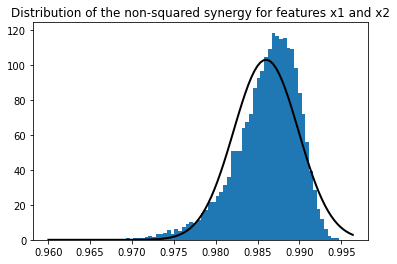

In [7]:
plot_nsq_distribution_train(0, 1, zero=False)

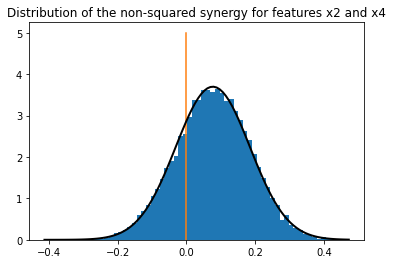

In [8]:
plot_nsq_distribution_train(1, 3)

P-VALUE

In [43]:
train_nsq_syn_list = np.load('Save_arrays/train_nsq_syn_list.npy')
pvalues = np.asarray([[pvalue0(train_nsq_syn_list[:, i, j]) for j in range(5)] for i in range(5)])
for i in range(5):
    pvalues[i, i]=None


In [10]:
pvalues

array([[      nan, 0.000e+00, 0.000e+00, 4.114e-01, 4.506e-01],
       [0.000e+00,       nan, 1.000e-04, 2.372e-01, 3.837e-01],
       [0.000e+00, 0.000e+00,       nan, 2.816e-01, 4.504e-01],
       [6.180e-02, 3.390e-02, 4.990e-02,       nan, 3.065e-01],
       [4.060e-02, 6.410e-02, 5.040e-02, 1.778e-01,       nan]])

In [6]:
def pvalue(distribution):
    return st.norm.cdf(0,np.mean(distribution),np.std(distribution))

STANDARD MODEL

In [32]:
shap_values = np.load('Save_arrays/shap_vals_train.npy')
shap_interaction_values = np.load('Save_arrays/shap_vals_int_train.npy')

train_nsq_syn_list=[]

for _ in range(10000):


    indices =  np.random.choice(7500,size=100)
    new_shap,new_inter=[],[]
    for i in indices:
        new_shap.append(shap_values[i])
        new_inter.append(shap_interaction_values[i])

    new_shap=np.asarray(new_shap)
    new_inter=np.asarray(new_inter)
    nsq_syn_matrix=np.zeros((5,5))
    

    for j in range(5):
        for i in range(5):
            pi = new_shap[:,i]
            pij = new_inter[:,i,j]


            nsq_syn_matrix[j,i]=np.inner(pi,pij)/(np.linalg.norm(pi)*(np.linalg.norm(pij)))
    
    
    train_nsq_syn_list.append(nsq_syn_matrix)

train_nsq_syn_list=np.asarray(train_nsq_syn_list)


In [33]:
def plot_nsq_distribution_train2(i,j,nsq_syn_list,zero=True,fit_norm=True):
    train_nsq_syn_list = nsq_syn_list
    plt.hist(train_nsq_syn_list[:,i,j],bins='auto',density=True)
    plt.title('Distribution of the non-squared synergy for features x'+str(i+1)+' and x'+str(j+1))
    if zero:
        plt.plot((0,0),(0,5))
    if fit_norm:
        mu,std= st.norm.fit(train_nsq_syn_list[:,i,j])
        xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = st.norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)

    
    return

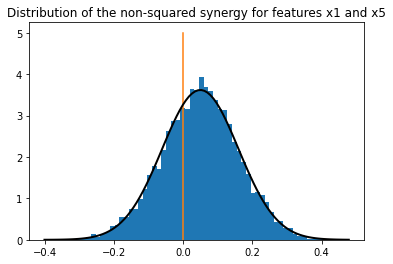

In [34]:
plot_nsq_distribution_train2(0,4,train_nsq_syn_list,zero=True,fit_norm=True)

In [35]:
pvalues = np.asarray([[pvalue0(train_nsq_syn_list[:,i,j]) for j in range(5)] for i in range(5)])
for i in range(5):
    pvalues[i,i]=None

In [36]:
pvalues

array([[   nan, 0.    , 0.    , 0.3792, 0.3204],
       [0.    ,    nan, 0.    , 0.4038, 0.4743],
       [0.    , 0.    ,    nan, 0.2427, 0.3723],
       [0.0436, 0.0401, 0.0377,    nan, 0.341 ],
       [0.0525, 0.0635, 0.0402, 0.2055,    nan]])

ANALYTICAL

In [37]:
shap_values = np.load('Save_arrays/shap_vals_train.npy')
shap_interaction_values = np.load('Save_arrays/shap_vals_int_train.npy')
big_shap_values = np.repeat(shap_values[:,:,np.newaxis],len(shap_values[0]),axis=2)
train_prods = big_shap_values*shap_interaction_values

In [38]:
train_mean_prods = np.mean(train_prods,axis=0)
train_std_prods = np.std(train_prods,axis=0)

In [41]:
pvalues_an = [[st.norm.cdf(0,train_mean_prods[i,j]*100,train_std_prods[i,j]*10) for i in range(5)] for j in range(5)]

In [42]:
pvalues_an

[[0.989920650138652,
  1.3764934119497478e-14,
  5.3616503042170195e-14,
  0.3832279840959389,
  0.3262198215967248],
 [1.4555130666861136e-14,
  0.9987583425453402,
  0.00014046737087650986,
  0.3990179738356891,
  0.4722583803695009],
 [5.913694944451652e-14,
  8.929385819908709e-05,
  0.9978761573402445,
  0.23109934407605842,
  0.373758002498935],
 [0.0490539274956478,
  0.05304926077395535,
  0.04530469289184194,
  4.389063915202416e-29,
  0.3368649828856568],
 [0.057267185422041046,
  0.07188190658506376,
  0.050437565171617564,
  0.20850175762219303,
  8.929133129420552e-29]]